In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft
from io import BytesIO

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

/tmp/ipykernel_116697/675125867.py:5: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy import ndimage
2025-12-03 02:32:59.926929: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 02:32:59.952498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-03 02:32:59.952518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-03 02:32:59.953355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to reg

In [2]:
k = 3   # kernel size
beta2s = [0, 0.25, 1] #[0, 0.25, 0.75, 1]  
activations = [tf.nn.relu]
timestamps = np.linspace(0, 100, num=100, dtype=np.int32)
print("Timestamps: ", timestamps)
experiment_name = "bipolar_circle"
box_dims = [200, 100]
step =   25 # Plot axis step

Timestamps:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98 100]


In [3]:
tf.nn.relu.__name__

'relu'

In [4]:
3//2

1

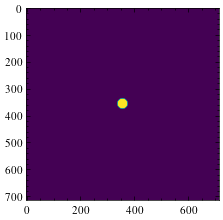

In [5]:
# Single pixel input
d = 715
mid = d//2

img = np.zeros((d,d)) # cv2.imread('input4.png', 0)/255. 


cv2.circle(img,(mid,mid), 19, (255.0), -1)
mid = img.shape[0]//2

plt.imshow(img)

In [6]:
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
filters = np.zeros((3,3,1,1))
img = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32)

2025-12-03 02:33:01.264803: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-03 02:33:01.305210: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-03 02:33:01.306636: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
import matplotlib.patches as mpatches
import imageio.v2 as imageio
from io import BytesIO

filters = np.zeros((3,3,1,1))

# Get image height and width
vals_x = img[0, img.shape[1]//2, :, :]
vals_y = img[0, :, img.shape[2]//2, :]
nonzeros = np.nonzero(vals_x)[0]
if nonzeros.size > 0:
    length_y = nonzeros[-1] - nonzeros[0] + 1
else:
    length_y = 0  # all zeros
nonzeros = np.nonzero(vals_x)[0]
if nonzeros.size > 0:
    length_x = nonzeros[-1] - nonzeros[0] + 1
else:
    length_x = 0  # all zeros

# step should be defined somewhere above in your code
# step = 2**np.floor(np.log2(((length_x) + np.max(timestamps)) // 5))

max_x = int(box_dims[0] * 0.75)
min_x = -int(box_dims[0] * 0.25)

max_y = box_dims[1] // 2
min_y = -(box_dims[1] // 2)

print(max_y, min_y)
print(length_x, length_y)

for activation in activations:
    directory = f"figures/{experiment_name}_{activation.__name__}_{k}x{k}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    for beta2 in beta2s:

        # ---- frames for this (activation, beta2) pair ----
        frames = []

        filters = np.zeros((3,3,1,1))

        t = np.zeros((3,3))
        t[1, 0] = np.sqrt(beta2)
        t[0, 0] = np.sqrt(1 - beta2)
        filters = np.reshape(fft.idctn(t, norm='ortho'), (3,3,1,1))
        print(tf.math.reduce_euclidean_norm(filters))
        # filters /= tf.math.reduce_euclidean_norm(filters)

        w = tf.cast(filters, dtype=tf.float32)
        w = tf.transpose(w, perm=(1, 0, 2, 3))

        x = img

        # evolve in time
        png_counter = 0
        for i in timestamps:
            x = x / np.std(x)

            # --- single-frame figure for this timestamp ---
            fig, ax = plt.subplots(figsize=(6, 6))

            print(np.std(x))
            vals = x[0, x.shape[1]//2, :, :]
            vals = vals / np.sum(vals)

            pos = np.expand_dims(
                np.linspace(-(x.shape[1]//2), x.shape[1]//2, x.shape[1]),
                -1
            )
            mean = tf.reduce_sum(pos * vals)
            var = tf.reduce_sum(((pos - mean)**2) * vals)
            std = np.sqrt(var)

            im = ax.imshow(x[0, :, :, 0])
            ax.plot(mid, mid, marker='+', color='red')

            ax.annotate(r'$\sigma_x=$' + f"{std:.2f}",
                        (0.05, 0.01),
                        ha='left', va='bottom',
                        color='white',
                        xycoords='axes fraction',
                        fontsize=15)
            ax.annotate(r'$\mu_x=$' + f"{mean:.2f}",
                        (0.05, 0.14),
                        ha='left', va='bottom',
                        color='white',
                        xycoords='axes fraction',
                        fontsize=15)

            ax.set(
                xlim=((mid + min_x, mid + max_x)),
                ylim=((mid + min_y, mid + max_y))
            )

            # re-label ticks relative to midpoint
            xticks = np.arange(
                np.sign(min_x) * (np.abs(min_x)//2) * 2,
                step + (max_x//2) * 2,
                step=step
            ) + mid
            yticks = np.arange(
                np.sign(min_y) * (np.abs(min_y)//2) * 2,
                step + (max_y//2) * 2,
                step=step
            ) + mid

            ax.set_xticks(xticks)
            ax.set_yticks(yticks)
            ax.tick_params(axis='x', labelsize=15)
            ax.tick_params(axis='y', labelsize=15)

            ax.set_xticklabels([x_tick - mid for x_tick in xticks])
            ax.set_yticklabels([y_tick - mid for y_tick in yticks])

            if beta2 == 0:
                ax.set_title(f"t={i}", fontsize=25)

            fig.tight_layout()

            # ---- capture frame into memory ----
            buf = BytesIO()
            fig.savefig(buf, format="png", dpi=fig.dpi, bbox_inches="tight")
            buf.seek(0)
            frame = imageio.imread(buf)
            frames.append(frame)

            # ALSO SAVE INDIVIDUAL FRAMES AS PNG
            frame_dir = os.path.join(directory, f"frames_{beta2}")
            os.makedirs(frame_dir, exist_ok=True)

            # Save first frame 50 times
            if i == timestamps[0]:
                repeats = 50
            else:
                repeats = 1

            '''for _ in range(repeats):
                png_path = os.path.join(
                    frame_dir,
                    f"frame_{activation.__name__}_{beta2}_{png_counter}.png"
                )

                fig.savefig(png_path, format="png", dpi=fig.dpi, bbox_inches="tight")
                png_counter += 1'''




            plt.close(fig)
            print(f"Step {i} done.")
            x = activation(
                tf.nn.conv2d(x, w, strides=(1, 1), padding='SAME')
            )
            w = np.rot90(w, k=2, axes=(0,1))

            print(np.max(x))

        # ---- save GIF for this (activation, beta2) ----
        # --- stay longer on the first frame (pad with copies) ---
        hold_first = 50  # increase for longer pause
        from PIL import Image

        # ---- save GIF for this (activation, beta2) ----
        if len(frames) > 0:
            # Ensure uint8 for Pillow
            frames_uint8 = []
            for f in frames:
                if f.dtype != np.uint8:
                    # assume f is float in [0,1] or [0,255]; adjust as needed
                    f_norm = f
                    if f_norm.max() <= 1.5:
                        f_norm = (f_norm * 255.0)
                    frames_uint8.append(f_norm.astype(np.uint8))
                else:
                    frames_uint8.append(f)

            pil_frames = [Image.fromarray(f) for f in frames_uint8]

            # durations in *milliseconds* per frame
            first_duration_ms = 1000   # 5 seconds for first frame
            rest_duration_ms  = 100    # 0.3 seconds for others

            durations_ms = [first_duration_ms] + [rest_duration_ms] * (len(pil_frames) - 1)

            gif_path = os.path.join(
                directory,
                f"{experiment_name}_{k}x{k}__{activation.__name__}_{beta2}.gif"
            )

            pil_frames[0].save(
                gif_path,
                save_all=True,
                append_images=pil_frames[1:],
                duration=durations_ms,   # per-frame durations
                loop=0                   # 0 = infinite loop
            )
            print(f"Saved GIF to {gif_path}")



2025-12-03 02:33:01.672964: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-12-03 02:33:01.672982: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-12-03 02:33:01.672997: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-12-03 02:33:01.673017: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

50 -50
39 39
tf.Tensor(1.0, shape=(), dtype=float64)
0.9999993
Step 0 done.


2025-12-03 02:33:01.910740: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-12-03 02:33:01.956970: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-12-03 02:33:01.958684: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-12-03 02:33:02.080073: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-12-03 02:33:02.081824: W ten

63.908737
1.0000005
Step 1 done.
65.53793
0.9999999
Step 2 done.
66.24911
0.99999964
Step 3 done.
66.80411
0.99999934
Step 4 done.
67.28193
0.9999993
Step 5 done.
67.71098
1.0000006
Step 6 done.
68.10561
0.9999992
Step 7 done.
68.47407
0.99999964
Step 8 done.
68.8221
1.0000004
Step 9 done.
69.1535
1.0000005
Step 10 done.
69.47085
0.9999999
Step 11 done.
69.77634
1.0000005
Step 12 done.
70.0717
1.0000004
Step 13 done.
70.35814
0.99999946
Step 14 done.
70.63659
0.9999993
Step 15 done.
70.90812
0.9999999
Step 16 done.
71.17335
0.99999976
Step 17 done.
71.4329
0.9999996
Step 18 done.
71.68727
0.9999993
Step 19 done.
71.93691
0.99999917
Step 20 done.
72.182205
1.0000004
Step 21 done.
72.4236
1.0000002
Step 22 done.
72.661156
1.0
Step 23 done.
72.8952
0.99999976
Step 24 done.
73.125946
1.0000001
Step 25 done.
73.35367
0.99999994
Step 26 done.
73.57828
0.99999964
Step 27 done.
73.79998
1.0000001
Step 28 done.
74.01895
0.9999997
Step 29 done.
74.23502
1.0000008
Step 30 done.
74.44844
0.9999999

In [9]:
len(frames)

100

In [10]:
pil_frames

[<PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image image mode=RGBA size=586x304>,
 <PIL.Image.Image im

In [11]:
yticks#-mid

array([307, 332, 357, 382, 407])

In [12]:
step

25